# **link datase**t : https://drive.google.com/drive/folders/1pHRiLalr38XQJBUr7kN1-Ydm0Pu8_h9O
# **Run code melalui google drive** link di atas : folder model -> data_analysis.ipynb (untuk analisis data) | model_cnn.ipynb untuk pemodelan

In [1]:
# Importing Libraries
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display

# audio plot 
from scipy.io import wavfile as wav
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv1D, Activation, Flatten, Dense,GlobalAveragePooling1D, Dropout, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Datmin UAS/"
print(os.listdir(path))

['trimmed_manusia', 'manusia', 'trimmer code', 'trimmed_tts', 'Model (1)', 'class', 'Tambahan (Suara Manusia)', 'TTS data 20 + 20', 'Model']


In [4]:
# Load Dataset
path = "/content/drive/MyDrive/Datmin UAS/"
path_manusia = "/content/drive/MyDrive/Datmin UAS/trimmed_manusia/"
path_tts = "/content/drive/MyDrive/Datmin UAS/trimmed_tts/"

In [5]:
#Prepare Data
data_train = list(glob.glob(path+'/**/*.wav'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], data_train))
file_path = pd.Series(data_train, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data = data[data.Labels != 'class']
data = data[data.Labels != 'Tambahan (Suara Manusia)']
data = data[data.Labels != 'TTS data 20 + 20']


data.head()



,File_Path,Labels
0,/content/drive/MyDrive/Datmin UAS/trimmed_manu...,trimmed_manusia
1,/content/drive/MyDrive/Datmin UAS/trimmed_manu...,trimmed_manusia
2,/content/drive/MyDrive/Datmin UAS/trimmed_tts/...,trimmed_tts
3,/content/drive/MyDrive/Datmin UAS/trimmed_tts/...,trimmed_tts
4,/content/drive/MyDrive/Datmin UAS/trimmed_manu...,trimmed_manusia


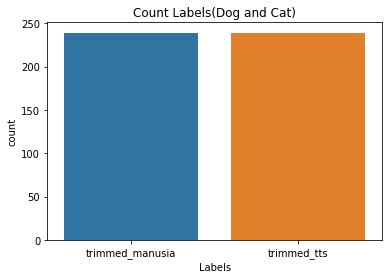

trimmed_manusia    239
trimmed_tts        239
Name: Labels, dtype: int64

In [6]:
#EDA & Visualization
sns.countplot(x='Labels', data=data)
plt.title('Count Labels(Dog and Cat)')
plt.show()
data['Labels'].value_counts()

In [7]:
def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [9]:
X, Y = [], []
for path, emotion in zip(data.File_Path, data.Labels):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [10]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.072718,0.257500,0.233406,0.226188,0.280225,0.275721,0.352861,0.338557,0.441913,0.680447,...,0.000023,0.000034,0.000053,0.000081,0.000052,0.000039,0.000013,5.644286e-06,4.431140e-06,trimmed_manusia
1,0.098402,0.290333,0.260447,0.282406,0.323051,0.334948,0.385765,0.364106,0.541846,0.695168,...,0.000959,0.001009,0.000981,0.001018,0.000979,0.000969,0.000929,1.033226e-03,9.965028e-04,trimmed_manusia
2,0.085605,0.287791,0.257705,0.224446,0.284970,0.292955,0.338435,0.335316,0.436603,0.717311,...,0.000006,0.000005,0.000007,0.000008,0.000018,0.000017,0.000007,3.865219e-06,3.366940e-06,trimmed_manusia
3,0.096847,0.416755,0.426715,0.497403,0.550624,0.478473,0.476163,0.548842,0.706878,0.685144,...,0.000007,0.000008,0.000010,0.000022,0.000021,0.000021,0.000009,1.009505e-06,3.919322e-07,trimmed_manusia
4,0.279283,0.539433,0.553431,0.601811,0.686446,0.651020,0.604370,0.611997,0.723992,0.717314,...,0.005277,0.004882,0.005232,0.005337,0.005230,0.005176,0.005168,5.336315e-03,5.311970e-03,trimmed_manusia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,0.043086,0.436114,0.725285,0.339924,0.252276,0.331246,0.412514,0.812879,0.397220,0.298305,...,0.000491,0.000460,0.000464,0.000447,0.000444,0.000407,0.000387,3.619737e-04,3.652386e-04,trimmed_manusia
1430,0.031641,0.313314,0.391307,0.200397,0.123008,0.160177,0.328964,0.799602,0.341298,0.214603,...,0.000064,0.000044,0.000032,0.000031,0.000034,0.000014,0.000004,5.266823e-07,2.892785e-07,trimmed_manusia
1431,0.122767,0.415636,0.225559,0.188088,0.214373,0.234979,0.390589,0.512587,0.260732,0.229040,...,0.036401,0.038818,0.034482,0.020014,0.016535,0.011759,0.002328,1.060531e-04,1.051278e-05,trimmed_manusia
1432,0.220866,0.455140,0.357468,0.352435,0.357070,0.409241,0.523165,0.532301,0.352785,0.370351,...,0.051884,0.055529,0.052115,0.034541,0.032516,0.029097,0.019473,1.671800e-02,1.723248e-02,trimmed_manusia


In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [12]:
# As this is a multiclass classification problem onehotencoding our Y.
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [13]:
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [14]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1075, 162), (1075, 2), (359, 162), (359, 2))

In [15]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1075, 162, 1), (1075, 2), (359, 162, 1), (359, 2))

In [16]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [17]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
17/17 [==============================] - 9s 438ms/step - loss: 1.8352 - accuracy: 0.5470 - val_loss: 0.6448 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 7s 416ms/step - loss: 0.6176 - accuracy: 0.6260 - val_loss: 0.5343 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 7s 419ms/step - loss: 0.5524 - accuracy: 0.6791 - val_loss: 0.4630 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 7s 418ms/step - loss: 0.5089 - accuracy: 0.7470 - val_loss: 0.3806 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 7s 414ms/step - loss: 0.4754 - accuracy: 0.7581 - val_loss: 0.3931 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 7s 417ms/step - loss: 0.4268 - accuracy: 0.7572 - val_loss: 0.3238 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 7s 416ms/step - lo

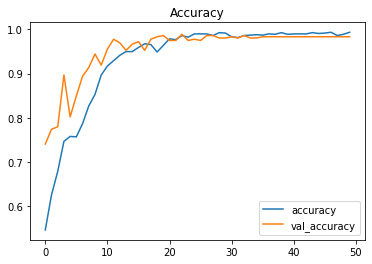

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()



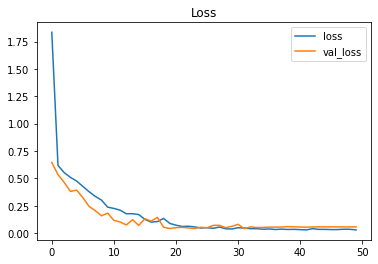

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [20]:
#Evaluating The Model
# Evaluating The Model
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 99.91%
Testing Accuracy: 98.33%


In [21]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

12/12 [==============================] - 1s 43ms/step


In [22]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

trimmed_manusia       0.98      0.98      0.98       180
    trimmed_tts       0.98      0.98      0.98       179

       accuracy                           0.98       359
      macro avg       0.98      0.98      0.98       359
   weighted avg       0.98      0.98      0.98       359



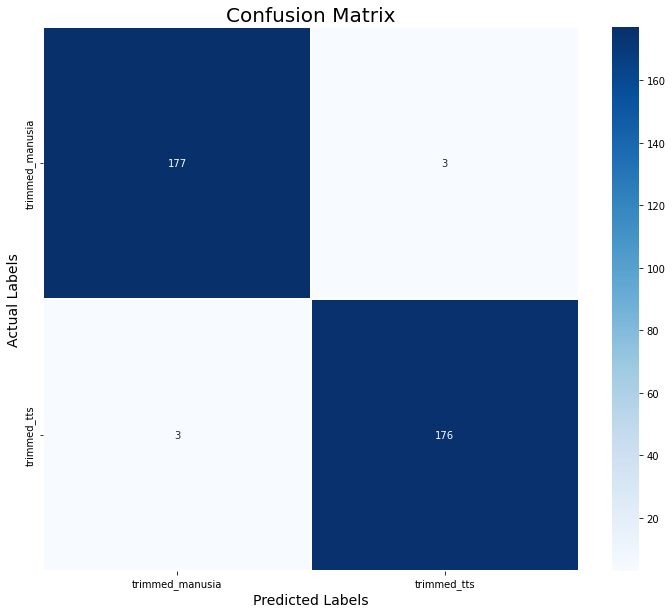

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [24]:
from tensorflow.keras.models import Sequential, save_model, load_model


In [25]:
# File path
filepath = '/content/drive/MyDrive/Datmin UAS/Model/speechrecognition.h5'

# Load the model
model = load_model(filepath, compile = True)

In [26]:
audio = get_features("/content/drive/MyDrive/Datmin UAS/trimmed_manusia/akl_11.wav")

In [27]:
audio

array([[ 1.22766565e-01,  4.15635824e-01,  2.25558817e-01,
         1.88087776e-01,  2.14373484e-01,  2.34978765e-01,
         3.90589029e-01,  5.12586832e-01,  2.60731816e-01,
         2.29039639e-01,  3.52980465e-01,  5.14641285e-01,
         6.68370426e-01, -2.55389282e+02,  4.14296417e+01,
        -5.61948509e+01, -5.09235420e+01, -3.52724342e+01,
        -1.27086000e+01,  9.49916935e+00, -1.61059761e+01,
        -1.52609816e+01, -2.59267759e+00, -1.84330978e+01,
        -9.41287136e+00, -7.58320904e+00,  1.81725082e+01,
         1.87873764e+01,  4.18638000e+01,  1.83412323e+01,
         6.36037052e-01, -2.05704460e+01,  1.56277418e+00,
         2.43159190e-01,  3.06132045e-02,  7.61152897e-03,
         2.34157941e-03,  1.55013578e-03,  1.79780368e-03,
         1.99249340e-03,  1.26953889e-03,  6.32191892e-04,
         7.11331784e-04,  1.13090628e-03,  4.06445237e-03,
         1.06526194e-02,  6.11702763e-02,  3.80280048e-01,
         3.14990544e+00,  6.55739822e+01,  1.41516235e+0

In [28]:
predictions = model.predict(audio)
print(predictions)

1/1 [==============================] - 0s 174ms/step
[[1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 7.0064935e-32]]
